In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ODMSGD import ODMSGD
from utils import *

In [2]:
p = 3
sigma = 0.1
beta_true = [0.3, -0.1, 0.7, 0.8, 0.5, -0.4]

# Data Generation

In [3]:
O = LinearGenerator(beta_true, sigma, n = 10000, generate_Y = True)
X, A, Y = O

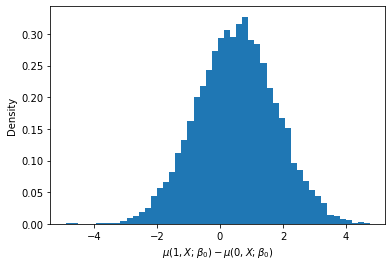

In [4]:
plt.hist(Y['1'] - Y['0'], 50, density=True)
plt.xlabel(r'$\mu(1, X; \beta_0) - \mu(0, X; \beta_0)$')
plt.ylabel('Density')
plt.savefig("linear_data.pdf")

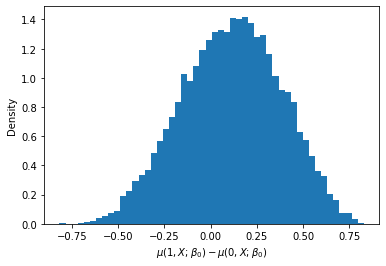

In [5]:
plt.hist(sigmoid(Y['1']) - sigmoid(Y['0']), 50, density=True)
plt.xlabel(r'$\mu(1, X; \beta_0) - \mu(0, X; \beta_0)$')
plt.ylabel('Density')
plt.savefig("logistic_data.pdf")

# Simulation Study -- Linear Model Setting
 

## Evaluation of the truth
Pure exploration for the first 50 step, then $\varepsilon_t = \varepsilon_\infty = 0.1$. Learning rate is $0.5t^{-0.501}$.

In [6]:
def eps(t):
    if t <= 50:
        return(1)
    else:
        return(0.1)
        #return(min(1, 0.1 * np.log(t)/np.sqrt(t)))
        
def generator(n=1, X=None, A=None, generate_Y=False):
    return LinearGenerator(beta_true, sigma, n, X, A, generate_Y)
        
LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                     eps=eps, eps_inf=0.1, alpha=0.5, gamma=0.501)

In [7]:
N = 1000000
X, _ = generator(N)
A = np.random.binomial(1, 0.5, N)
O = generator(N, X, A, True)
_, H = MSELoss(beta_true, O, return_second_moment=True)
epsilon = 0.1
d = np.array(u(1, X, beta_true) > u(0, X, beta_true), dtype = float)
pi = (1 - epsilon) * d + epsilon/2
from scipy.linalg import block_diag
S = block_diag(np.dot(X.T/(1-pi), X), np.dot(X.T/pi, X))/(4 * N) * sigma**2
H_inv = np.linalg.inv(H)
V = np.dot(np.dot(H_inv, S), H_inv)
val_true = np.mean(u(d, X, beta_true))
VV = (np.mean(u(d, X, beta_true)**2) + sigma**2) * 2/(2 - epsilon) - val_true**2

In [8]:
def stable(epsilon):
    N = 1000000
    X, _ = generator(N)
    A = np.random.binomial(1, 0.5, N)
    O = generator(N, X, A, True)
    _, H = MSELoss(beta_true, O, return_second_moment=True)
    d = np.array(u(1, X, beta_true) > u(0, X, beta_true), dtype = float)
    pi = (1 - epsilon) * d + epsilon/2
    S = block_diag(np.dot(X.T/(1-pi), X), np.dot(X.T/pi, X))/(4 * N) * sigma**2
    H_inv = np.linalg.inv(H)
    V = np.dot(np.dot(H_inv, S), H_inv)
    val_true = np.mean(u(d, X, beta_true))
    VV = (np.mean(u(d, X, beta_true)**2) + sigma**2) * 2/(2 - epsilon) - val_true**2
    print(np.round(np.append(np.diag(V), VV), 4))

In [9]:
for epsilon in [0.1, 0.01, 0.001, 0.0001]:
    stable(epsilon)

[0.1349 0.1286 0.1131 0.0757 0.0821 0.0975 0.2968]
[1.3148 1.2489 1.0857 0.6969 0.7631 0.9238 0.2301]
[13.072  12.3828 10.8418  6.9132  7.6193  9.2096  0.2235]
[130.8418 124.14   108.4163  69.0211  75.5079  91.4416   0.2231]


## Parameter and its variance estimation
### Plugin estimator is consistent

In [10]:
# Plugin Method
print('True beta    :', np.round(beta_true, 3))
print('TSE * sqrt(t):', np.round(np.sqrt(np.diag(V)), 3))
LinearModel.Initialize()
for T in [1000, 9000, 90000, 900000]:
    LinearModel.SGD(T)
    print('Step {:8}:'.format(LinearModel.step))
    print('beta estimate:', np.round(LinearModel.beta_bar, 3))
    print('PSE * sqrt(t):', np.round(LinearModel.se_hat * np.sqrt(LinearModel.step), 3))
    print('H estimate   :', np.round(np.diag(LinearModel.H_hat/LinearModel.step), 3))
    print('S estimate   :', np.round(np.diag(LinearModel.S_hat/LinearModel.step), 3))

True beta    : [ 0.3 -0.1  0.7  0.8  0.5 -0.4]
TSE * sqrt(t): [0.367 0.357 0.335 0.276 0.288 0.313]
Step     1000:
beta estimate: [ 0.307 -0.11   0.685  0.79   0.503 -0.368]
PSE * sqrt(t): [0.474 0.318 0.438 0.355 0.323 0.446]
H estimate   : [0.449 0.527 0.395 0.527 0.493 0.642]
S estimate   : [0.04  0.031 0.026 0.038 0.025 0.085]
Step    10000:
beta estimate: [ 0.304 -0.103  0.692  0.803  0.499 -0.392]
PSE * sqrt(t): [0.376 0.329 0.332 0.271 0.262 0.331]
H estimate   : [0.498 0.513 0.517 0.502 0.492 0.511]
S estimate   : [0.035 0.029 0.029 0.019 0.017 0.03 ]
Step   100000:
beta estimate: [ 0.302 -0.1    0.698  0.8    0.5   -0.398]
PSE * sqrt(t): [0.359 0.351 0.323 0.28  0.286 0.322]
H estimate   : [0.507 0.51  0.506 0.494 0.497 0.506]
S estimate   : [0.033 0.032 0.027 0.019 0.02  0.026]
Step  1000000:
beta estimate: [ 0.301 -0.1    0.699  0.8    0.501 -0.4  ]
PSE * sqrt(t): [0.365 0.355 0.332 0.275 0.291 0.311]
H estimate   : [0.499 0.505 0.499 0.501 0.501 0.505]
S estimate   : [0.033

In [11]:
print('H:')
print(np.round(H, 3))
print('H_hat:')
print(np.round(LinearModel.H_hat/LinearModel.step, 3))
print('S:')
print(np.round(S, 3))
print('S_hat:')
print(np.round(LinearModel.S_hat/LinearModel.step, 3))

H:
[[ 0.5    0.     0.001  0.     0.     0.   ]
 [ 0.     0.5    0.     0.     0.     0.   ]
 [ 0.001  0.     0.502  0.     0.     0.   ]
 [ 0.     0.     0.     0.5   -0.     0.   ]
 [ 0.     0.     0.    -0.     0.498 -0.   ]
 [ 0.     0.     0.     0.    -0.     0.499]]
H_hat:
[[0.499 0.    0.001 0.    0.    0.   ]
 [0.    0.505 0.002 0.    0.    0.   ]
 [0.001 0.002 0.499 0.    0.    0.   ]
 [0.    0.    0.    0.501 0.    0.002]
 [0.    0.    0.    0.    0.501 0.   ]
 [0.    0.    0.    0.002 0.    0.505]]
S:
[[ 0.034  0.008 -0.015  0.     0.     0.   ]
 [ 0.008  0.032  0.003  0.     0.     0.   ]
 [-0.015  0.003  0.028  0.     0.     0.   ]
 [ 0.     0.     0.     0.019 -0.008  0.015]
 [ 0.     0.     0.    -0.008  0.021 -0.003]
 [ 0.     0.     0.     0.015 -0.003  0.024]]
S_hat:
[[ 0.033  0.009 -0.015  0.     0.     0.   ]
 [ 0.009  0.032  0.003  0.     0.     0.   ]
 [-0.015  0.003  0.027  0.     0.     0.   ]
 [ 0.     0.     0.     0.019 -0.009  0.016]
 [ 0.     0.     0.    

### Tuning of learning rate

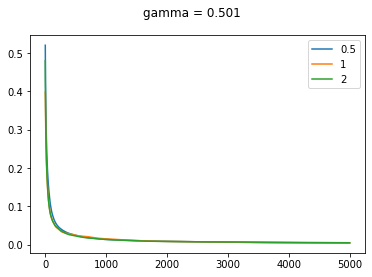

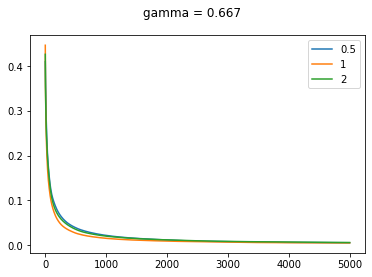

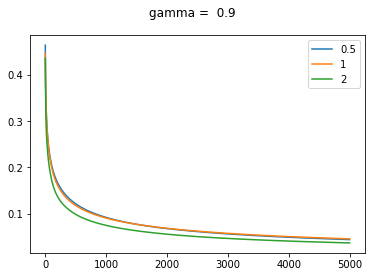

In [12]:
T = 5000
M = 10
for gamma in [0.501, 2/3, 0.9]:
    fig = plt.figure()
    fig.suptitle("gamma = {:4}".format(round(gamma, 3)))
    for alpha in [0.5, 1, 2]:
        LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                             eps=eps, eps_inf=0.1, alpha=0.5, gamma=gamma)
        MAE = np.zeros(T)
        for _ in range(M):
            LinearModel.Initialize()
            LinearModel.SGD(T)
            MAE += [np.mean(np.abs(beta-beta_true)) for beta in LinearModel.beta_bar_log[1:]]
        MAE /= M
        plt.plot(MAE, label = str(alpha))
    plt.legend()
    plt.show()

### Comparison of estimation methods
Plugin, Resampling and BatchMean estimators

In [ ]:
LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                     eps=eps, eps_inf=0.1, alpha=0.5, gamma=0.501)
# Plugin Method vs. Resampling Method
LinearModel.Initialize()
print('TSE * sqrt(t):', np.round(np.sqrt(np.diag(V)), 3))
for T in [1000, 9000, 90000, 900000]:
    LinearModel.DoubleWeighting(T = T, R = 200)
    print('Step {:8}:'.format(LinearModel.step))
    print('PSE * sqrt(t):', np.round(np.sqrt(np.diag(LinearModel.PluginParameterVariance())), 3))
    print('RSE * sqrt(t):', np.round(np.sqrt(np.diag(LinearModel.ResamplingParameterVariance() * LinearModel.step)), 3))

TSE * sqrt(t): [0.367 0.357 0.335 0.276 0.288 0.313]
Step     1000:
PSE * sqrt(t): [0.363 0.41  0.347 0.364 0.362 0.536]
RSE * sqrt(t): [0.773 0.664 0.735 1.191 2.188 1.449]
Step    10000:
PSE * sqrt(t): [0.377 0.43  0.387 0.299 0.311 0.346]
RSE * sqrt(t): [0.48  0.564 0.563 0.51  0.776 0.601]
Step   100000:
PSE * sqrt(t): [0.371 0.376 0.346 0.282 0.297 0.327]
RSE * sqrt(t): [0.403 0.379 0.387 0.328 0.379 0.4  ]


In [22]:
def MC(model, T, R, M):
    beta_bar = np.zeros((M, 2 * p))
    P_se_log = np.zeros((M, 2 * p))
    R_se_log = np.zeros((M, 2 * p))
    BM_se_log = np.zeros((M, 2 * p))
    P_cp = np.zeros(2 * p)
    R_cp = np.zeros(2 * p)
    BM_cp = np.zeros(2 * p)
    for i in range(M):
        model.Initialize()
        model.DoubleWeighting(T = T, R = R)
        beta_bar[i, :] = model.beta_bar
        P_se_i = np.sqrt(np.diag(model.PluginParameterVariance())/T)
        P_se_log[i, :] = P_se_i
        R_se_i = np.sqrt(np.diag(model.ResamplingParameterVariance()))
        R_se_log[i, :] = R_se_i
        BM_se_i = np.sqrt(np.diag(model.BatchMeansParameterVariance())/T)
        BM_se_log[i, :] = BM_se_i
        cover_P = np.abs(beta_true - model.beta_bar) <= 1.96 * P_se_i
        cover_R = np.abs(beta_true - model.beta_bar) <= 1.96 * R_se_i
        cover_BM = np.abs(beta_true - model.beta_bar) <= 1.96 * BM_se_i
        P_cp += np.array(cover_P, dtype=float)
        R_cp += np.array(cover_R, dtype=float)
        BM_cp += np.array(cover_BM, dtype=float)
    mcsd = np.std(beta_bar, axis = 0)
    P_se = np.mean(P_se_log, axis = 0)
    R_se = np.mean(R_se_log, axis = 0)
    BM_se = np.mean(BM_se_log, axis = 0)
    P_cp /= M
    R_cp /= M
    BM_cp /= M
    return(beta_bar, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp)

In [23]:
LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                     eps=eps, eps_inf=0.1, alpha=0.5, gamma=0.501)
print(' ' * 29 + 'b01  b02  b03  b11  b12  b13')
for T in [100]: #lr = 0.5*t^(-0.501)
    np.random.seed(1)
    beta_bar, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp = MC(LinearModel, T = T, R = 200, M = 200)
    print('PSE/MCSD at step {:8}:'.format(T), np.round(P_se/mcsd, 2))
    print('PluginCP at step {:8}:'.format(T), np.round(P_cp, 2))
    print('RSE/MCSD at step {:8}:'.format(T), np.round(R_se/mcsd, 2))
    print('ResampCP at step {:8}:'.format(T), np.round(R_cp, 2))
    print('BMSE/MCSD at step {:7}:'.format(T), np.round(BM_se/mcsd, 2))
    print('BtchMnCP at step {:8}:'.format(T), np.round(BM_cp, 2))

                             b01  b02  b03  b11  b12  b13
PSE/MCSD at step      100: [0.97 0.71 0.85 0.91 0.92 0.83]
PluginCP at step      100: [0.94 0.93 0.86 0.83 0.89 0.91]
RSE/MCSD at step      100: [1.91 1.65 1.73 1.96 1.93 1.88]
ResampCP at step      100: [1.   1.   0.89 0.94 0.92 0.97]
BMSE/MCSD at step     100: [0.44 0.32 0.43 0.5  0.44 0.4 ]
BtchMnCP at step      100: [0.55 0.52 0.39 0.41 0.52 0.48]


In [ ]:
# A parallel version of the above cell 
# Do not run on jupyter notebook

from multiprocessing import Pool
from functools import partial

def MC1(model, T, R):
    np.random.seed()
    model.Initialize()
    model.DoubleWeighting(T = T, R = R)
    P_se = np.sqrt(np.diag(model.PluginParameterVariance())/T)
    R_se = np.sqrt(np.diag(model.ResamplingParameterVariance()))
    BM_se = np.sqrt(np.diag(model.BatchMeansParameterVariance())/T)
    P_cp = np.array(np.abs(beta_true - model.beta_bar) <= 1.96 * P_se, dtype=float)
    R_cp = np.array(np.abs(beta_true - model.beta_bar) <= 1.96 * R_se, dtype=float)
    BM_cp = np.array(np.abs(beta_true - model.beta_bar) <= 1.96 * BM_se, dtype=float)
    return(model.beta_bar, P_se, P_cp, R_se, R_cp, BM_se, BM_cp)

def ParallelMC(model, T, R, M, num_procs):
    pool = Pool(num_procs)
    _MC1_ = partial(MC1, model=model, T=T, R=R)
    experiments = [pool.apply_async(_MC1_) for _ in range(M)]
    beta_bar = [e.get()[0] for e in experiments]
    P_se_log = [e.get()[1] for e in experiments]
    P_cp_log = [e.get()[2] for e in experiments]
    R_se_log = [e.get()[3] for e in experiments]
    R_cp_log = [e.get()[4] for e in experiments]
    BM_se_log = [e.get()[5] for e in experiments]
    BM_cp_log = [e.get()[6] for e in experiments]
    mcsd = np.std(beta_bar, axis=0)
    P_se = np.mean(P_se_log, axis=0)
    P_cp = np.mean(P_cp_log, axis=0)
    R_se = np.mean(R_se_log, axis=0)
    R_cp = np.mean(R_cp_log, axis=0)
    BM_se = np.mean(BM_se_log, axis=0)
    BM_cp = np.mean(BM_cp_log, axis=0)
    return(beta_bar, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp)

if __name__ == '__main__':
    LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                         eps=eps, eps_inf=0.1, alpha=0.5, gamma=2/3) #lr = 0.5*t^(-0.667)
    print(' ' * 29 + 'b01  b02  b03  b11  b12  b13')
    for T in [1000, 10000, 100000]:
        _, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp = ParallelMC(LinearModel, T=T, R=200, M=200, num_procs=16)
        print('PSE/MCSD at step {:8}:'.format(T), np.round(P_se/mcsd, 2))
        print('PluginCP at step {:8}:'.format(T), np.round(P_cp, 2))
        print('RSE/MCSD at step {:8}:'.format(T), np.round(R_se/mcsd, 2))
        print('ResampCP at step {:8}:'.format(T), np.round(R_cp, 2))
        print('BMSE/MCSD at step {:7}:'.format(T), np.round(BM_se/mcsd, 2))
        print('BtchMnCP at step {:8}:'.format(T), np.round(BM_cp, 2))
        
# Output:
#                              b01  b02  b03  b11  b12  b13
# PSE/MCSD at step     1000: [0.48 0.57 0.54 0.71 0.56 0.61]
# PluginCP at step     1000: [0.89 0.84 0.8  0.77 0.72 0.8 ]
# RSE/MCSD at step     1000: [1.93 2.89 2.35 2.73 2.5  2.46]
# ResampCP at step     1000: [1.   1.   0.95 1.   0.94 0.98]
# BMSE/MCSD at step    1000: [0.27 0.36 0.36 0.47 0.4  0.38]
# BtchMnCP at step     1000: [0.57 0.52 0.55 0.6  0.55 0.54]
# PSE/MCSD at step    10000: [0.77 0.64 0.85 0.79 0.76 0.73]
# PluginCP at step    10000: [0.9  0.86 0.91 0.89 0.85 0.92]
# RSE/MCSD at step    10000: [2.72 2.72 3.58 2.2  1.96 2.27]
# ResampCP at step    10000: [1.   1.   1.   0.98 0.98 1.  ]
# BMSE/MCSD at step   10000: [0.66 0.59 0.78 0.66 0.66 0.63]
# BtchMnCP at step    10000: [0.81 0.76 0.84 0.8  0.78 0.79]
# PSE/MCSD at step   100000: [0.92 1.01 0.95 0.89 0.96 0.91]
# PluginCP at step   100000: [0.94 0.96 0.94 0.91 0.94 0.92]
# RSE/MCSD at step   100000: [1.48 1.84 1.68 1.55 1.96 2.21]
# ResampCP at step   100000: [0.97 0.99 0.98 0.96 0.98 0.96]
# BMSE/MCSD at step  100000: [0.69 0.77 0.76 0.68 0.76 0.75]
# BtchMnCP at step   100000: [0.8  0.84 0.85 0.83 0.84 0.87]

if __name__ == '__main__':
    LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                     eps=eps, eps_inf=0.1, alpha=0.2, gamma=0.501) #lr = 0.2*t^(-0.501)
    print(' ' * 29 + 'b01  b02  b03  b11  b12  b13')
    for T in [1000, 10000, 100000]:
        _, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp = ParallelMC(LinearModel, T = T, R = 200, M = 200, num_procs = 16)
        print('PSE/MCSD at step {:8}:'.format(T), np.round(P_se/mcsd, 2))
        print('PluginCP at step {:8}:'.format(T), np.round(P_cp, 2))
        print('RSE/MCSD at step {:8}:'.format(T), np.round(R_se/mcsd, 2))
        print('ResampCP at step {:8}:'.format(T), np.round(R_cp, 2))
        print('BMSE/MCSD at step {:7}:'.format(T), np.round(BM_se/mcsd, 2))
        print('BtchMnCP at step {:8}:'.format(T), np.round(BM_cp, 2))
        
# Output:
# PSE/MCSD at step     1000: [0.8  0.66 0.61 0.82 0.72 0.7 ]
# PluginCP at step     1000: [0.88 0.86 0.72 0.51 0.64 0.77]
# RSE/MCSD at step     1000: [1.95 1.96 1.63 2.09 2.03 1.89]
# ResampCP at step     1000: [1.   1.   0.92 0.86 0.9  0.93]
# BMSE/MCSD at step    1000: [0.27 0.23 0.29 0.5  0.36 0.31]
# BtchMnCP at step     1000: [0.38 0.34 0.27 0.2  0.27 0.34]
# PSE/MCSD at step    10000: [0.78 0.85 0.71 0.95 0.81 0.93]
# PluginCP at step    10000: [0.92 0.9  0.86 0.81 0.82 0.92]
# RSE/MCSD at step    10000: [1.72 1.96 1.71 1.6  1.42 1.69]
# ResampCP at step    10000: [0.97 0.98 0.96 0.95 0.94 0.98]
# BMSE/MCSD at step   10000: [0.39 0.44 0.4  0.54 0.44 0.47]
# BtchMnCP at step    10000: [0.55 0.64 0.6  0.49 0.54 0.56]
# PSE/MCSD at step   100000: [0.99 0.98 1.09 0.95 0.9  0.89]
# PluginCP at step   100000: [0.96 0.96 0.96 0.9  0.92 0.92]
# RSE/MCSD at step   100000: [1.29 1.36 1.52 1.15 1.18 1.14]
# ResampCP at step   100000: [0.98 1.   0.99 0.94 0.96 0.96]
# BMSE/MCSD at step  100000: [0.49 0.49 0.54 0.48 0.45 0.45]
# BtchMnCP at step   100000: [0.64 0.63 0.7  0.61 0.6  0.62]

In [24]:
ax = np.array([[0.48, 0.57, 0.54, 0.71, 0.56, 0.61],
               [0.77, 0.64, 0.85, 0.79, 0.76, 0.73],
               [0.92, 1.01, 0.95, 0.89, 0.96, 0.91]])
ay = np.array([[0.89, 0.84, 0.8 , 0.77, 0.72, 0.8 ],
               [0.9 , 0.86, 0.91, 0.89, 0.85, 0.92],
               [0.94, 0.96, 0.94, 0.91, 0.94, 0.92]])
bx = np.array([[1.93, 2.89, 2.35, 2.73, 2.5 , 2.46],
               [2.72, 2.72, 3.58, 2.2 , 1.96, 2.27],
               [1.48, 1.84, 1.68, 1.55, 1.96, 2.21]])
by = np.array([[1.  , 1.  , 0.95, 1.  , 0.94, 0.98],
               [1.  , 1.  , 1.  , 0.98, 0.98, 1.  ],
               [0.97, 0.99, 0.98, 0.96, 0.98, 0.96]])
cx = np.array([[0.27, 0.36, 0.36, 0.47, 0.4 , 0.38],
               [0.66, 0.59, 0.78, 0.66, 0.66, 0.63],
               [0.69, 0.77, 0.76, 0.68, 0.76, 0.75]])
cy = np.array([[0.57, 0.52, 0.55, 0.6 , 0.55, 0.54],
               [0.81, 0.76, 0.84, 0.8 , 0.78, 0.79],
               [0.8 , 0.84, 0.85, 0.83, 0.84, 0.87]])

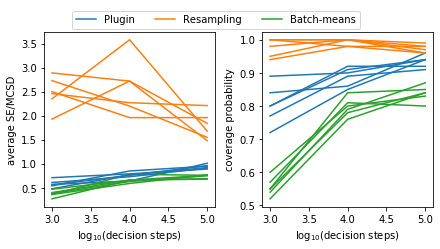

In [25]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)

T = [1000, 10000, 100000]
x = [ax, bx, cx]
y = [ay, by, cy]
method = ['Plugin', 'Resampling', 'Batch-means']
for j in range(6):
    for k in range(3):
        if j == 0:
            ax1.plot(np.log10(T), x[k][:, j], color = colors[k], label = method[k])
        else:
            ax1.plot(np.log10(T), x[k][:, j], color = colors[k])
        ax2.plot(np.log10(T), y[k][:, j], color = colors[k])
ax1.set_xlabel("$\log_{10}$(decision steps)")
ax1.set_ylabel("average SE/MCSD")
ax2.set_xlabel("$\log_{10}$(decision steps)")
ax2.set_ylabel("coverage probability")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=3)
plt.savefig("linear_variance_estimation.pdf", bbox_inches='tight')

In [233]:
# Mini-Batch Method
print('TSE * sqrt(t):', np.round(np.sqrt(np.diag(V)), 3))
LinearModel.Initialize()
for T in [1000, 9000, 90000, 900000]:
    LinearModel.MBGD(T = T, B = 10)
    print('Step {:7}:'.format(LinearModel.step))
    print('beta estimate:', np.round(LinearModel.beta_bar, 3))
    print('se estimate  :', np.round(LinearModel.se_hat * np.sqrt(LinearModel.step), 3))
    print('H estimate   :', np.round(np.diag(LinearModel.H_hat/LinearModel.step), 3))
    print('S estimate   :', np.round(np.diag(LinearModel.S_hat/LinearModel.step), 3))

TSE * sqrt(t): [0.515 0.502 0.471 0.381 0.397 0.434]
Step    1000:
beta estimate: [ 0.141 -0.04   0.219  0.217  0.087 -0.14 ]
se estimate  : [1.468 1.023 2.185 2.384 1.824 2.298]
H estimate   : [0.434 0.561 0.325 0.439 0.34  0.331]
S estimate   : [0.256 0.325 0.379 0.877 0.376 0.422]
Step   10000:
beta estimate: [ 0.223 -0.052  0.416  0.48   0.288 -0.246]
se estimate  : [1.518 1.812 2.5   1.314 1.92  1.379]
H estimate   : [0.5   0.51  0.494 0.519 0.54  0.547]
S estimate   : [0.566 0.9   1.555 0.475 1.093 0.608]
Step  100000:
beta estimate: [ 0.273 -0.084  0.616  0.703  0.433 -0.352]
se estimate  : [0.909 0.965 1.362 0.682 0.893 0.8  ]
H estimate   : [0.488 0.487 0.497 0.494 0.493 0.495]
S estimate   : [0.192 0.222 0.452 0.113 0.194 0.157]
Step 1000000:
beta estimate: [ 0.295 -0.099  0.688  0.785  0.49  -0.393]
se estimate  : [0.579 0.579 0.649 0.431 0.488 0.498]
H estimate   : [0.496 0.492 0.496 0.501 0.502 0.501]
S estimate   : [0.082 0.081 0.103 0.047 0.06  0.062]


## Value and its variance estimation

In [26]:
def eps(t):
    if t <= 50:
        return(1)
    else:
        return(max(t**(-0.3), 0.1))
    
LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                     eps=eps, eps_inf=0.1, alpha=0.5, gamma=0.501)

In [27]:
print(' ' * 14 + 'Value VSE*rt')
print('True       : {:6} {:6}'.format(round(val_true, 4), round(np.sqrt(VV), 4)))
LinearModel.Initialize()
np.random.seed(2)
for T in [1000, 9000, 90000]:
    LinearModel.SGD(T)
    #etasq_hat = LinearModel.PluginValueVariance()
    print('Step {:6}: {:6} {:6}'.format(LinearModel.step, 
                                             np.round(LinearModel.val_hat, 4), 
                                             np.round(LinearModel.vse_hat * np.sqrt(LinearModel.step), 4)))

              Value VSE*rt
True       : 1.0895  0.545
Step   1000: 1.0642 0.5658
Step  10000: 1.0888 0.5496
Step 100000: 1.0862 0.5424


In [19]:
def MCPluginSeq(model, T, M):
    beta_bar = np.zeros((M, T, 2 * p))
    val_hat = np.zeros((M, T))
    for i in range(M):
        model.Initialize()
        model.SGD(T)
        beta_bar[i, :, :] = model.beta_bar_log[1:]
        val_hat[i, :] = model.val_hat_log
    beta_bar_m = np.mean(beta_bar, axis = 0)
    beta_bar_u = np.quantile(beta_bar, q = 0.975, axis = 0)
    beta_bar_l = np.quantile(beta_bar, q = 0.025, axis = 0)
    val_hat_m = np.mean(val_hat, axis = 0)
    val_hat_u = np.quantile(val_hat, q = 0.975, axis = 0)
    val_hat_l = np.quantile(val_hat, q = 0.025, axis = 0)
    return(beta_bar_m, beta_bar_u, beta_bar_l, val_hat_m, val_hat_u, val_hat_l)

In [20]:
LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                     eps=eps, eps_inf=0.1, alpha=0.5, gamma=0.501)
for T in [10000]: #lr = 0.5*t^(-0.501)
    np.random.seed(0)
    beta_bar_m, beta_bar_u, beta_bar_l, val_hat_m, val_hat_u, val_hat_l = MCPluginSeq(LinearModel, T = T, M = 200)

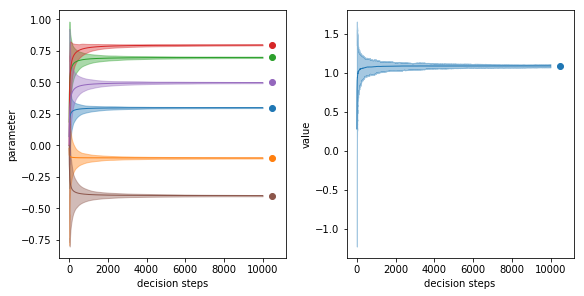

In [21]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

for i in range(2 * p):
    ax1.plot(beta_bar_m[:, i], lw = 1, color = colors[i])
    ax1.fill_between(np.arange(10000), beta_bar_l[:, i], beta_bar_u[:, i], color = colors[i], alpha = 0.4)
    ax1.scatter(10500, beta_true[i], color = colors[i])
    ax1.set_xlabel("decision steps")
    ax1.set_ylabel("parameter")

ax2.plot(val_hat_m, lw = 1, color = colors[0], label = 'Fit')
ax2.fill_between(np.arange(10000), val_hat_l, val_hat_u, color = colors[0], alpha = 0.4, label = '95% CI')
ax2.scatter(10500, val_true, color = colors[0])
ax2.set_xlabel("decision steps")
ax2.set_ylabel("value")

plt.show()

In [18]:
def MCPlugin(model, T, M):
    beta_bar = np.zeros((M, 2 * p))
    val_hat = np.zeros(M)
    P_se_log = np.zeros((M, 2 * p))
    V_se_log = np.zeros(M)
    P_cp = np.zeros(2 * p)
    V_cp = 0.
    for i in range(M):
        model.Initialize()
        model.SGD(T)
        beta_bar[i, :] = model.beta_bar
        val_hat[i] = model.val_hat
        P_se_log[i, :] = model.se_hat
        V_se_log[i] = model.vse_hat
        P_cover = np.abs(beta_true - model.beta_bar) <= 1.96 * model.se_hat
        V_cover = np.abs(val_true - model.val_hat) <= 1.96 * model.vse_hat
        P_cp += np.array(P_cover, dtype = float)
        V_cp += float(V_cover)
    P_mcsd = np.std(beta_bar, axis = 0)
    V_mcsd = np.std(val_hat, axis = 0)
    P_se = np.mean(P_se_log, axis = 0)
    V_se = np.mean(V_se_log, axis = 0)
    P_cp /= M
    V_cp /= M
    return(beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_se, V_cp)

In [19]:
LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                     eps=eps, eps_inf=0.1, alpha=0.5, gamma=0.501)
print(' ' * 25 + '[ b01  b02  b03  b11  b12  b13]  val')
for T in [1000, 10000]: #lr = 0.5*t^(-0.501)
    np.random.seed(0)
    beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_se, V_cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:6}:'.format(T), np.round(P_se/P_mcsd, 2), round(V_se/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), np.round(P_cp, 2), round(V_cp, 2))

                         [ b01  b02  b03  b11  b12  b13]  val
ASE/MCSD at step   1000: [1.   0.84 0.73 0.85 0.82 0.78] 0.96
CvrgProb at step   1000: [0.95 0.94 0.86 0.87 0.84 0.9 ] 0.93
ASE/MCSD at step  10000: [1.02 0.92 0.91 1.04 0.95 0.9 ] 1.01
CvrgProb at step  10000: [0.95 0.94 0.9  0.96 0.94 0.92] 0.93


In [22]:
LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                     eps=eps, eps_inf=0.1, alpha=0.5, gamma=2/3)
print(' ' * 25 + '[ b01  b02  b03  b11  b12  b13]  val')
for T in [1000, 10000]: #lr = 0.5*t^(-0.667)
    np.random.seed(0)
    beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_se, V_cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:6}:'.format(T), np.round(P_se/P_mcsd, 2), round(V_se/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), np.round(P_cp, 2), round(V_cp, 2))

                         [ b01  b02  b03  b11  b12  b13]  val
ASE/MCSD at step   1000: [0.97 0.94 0.9  0.89 0.81 0.76] 0.91
CvrgProb at step   1000: [0.94 0.95 0.93 0.89 0.86 0.88] 0.91
ASE/MCSD at step  10000: [1.01 0.98 0.92 1.03 0.9  0.92] 1.01
CvrgProb at step  10000: [0.96 0.95 0.92 0.96 0.92 0.92] 0.93


In [19]:
def MCPluginF(model, T, M):
    beta_bar = np.zeros((M, 2 * p))
    val_hat = np.zeros(M)
    P_se_log = np.zeros((M, 2 * p))
    V_ose_log = np.zeros(M)
    V_fse_log = np.zeros(M)
    P_cp = np.zeros(2 * p)
    V_ocp = 0.
    V_fcp = 0.
    for i in range(M):
        model.Initialize()
        model.SGD(T)
        beta_bar[i, :] = model.beta_bar
        val_hat[i] = model.val_hat
        P_se_log[i, :] = model.se_hat
        V_ose_log[i] = model.vse_hat
        V_fse_log[i] = np.sqrt(model.PluginValueVariance()/model.step)
        P_cover = np.abs(beta_true - model.beta_bar) <= 1.96 * model.se_hat
        V_ocover = np.abs(val_true - model.val_hat) <= 1.96 * model.vse_hat
        V_fcover = np.abs(val_true - model.val_hat) <= 1.96 * V_fse_log[i]
        P_cp += np.array(P_cover, dtype=float)
        V_ocp += float(V_ocover)
        V_fcp += float(V_fcover)
    P_mcsd = np.std(beta_bar, axis = 0)
    V_mcsd = np.std(val_hat, axis = 0)
    P_se = np.mean(P_se_log, axis = 0)
    V_ose = np.mean(V_ose_log, axis = 0)
    V_fse = np.mean(V_fse_log, axis = 0)
    P_cp /= M
    V_ocp /= M
    V_fcp /= M
    return(beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_ose, V_ocp, V_fse, V_fcp)

In [117]:
LinearModel = ODMSGD(p=p, mu=u, generator=generator, loss=MSELoss,
                     eps=eps, eps_inf=0.1, alpha=0.5, gamma=0.501)
print(' ' * 25 + '[ b01  b02  b03  b11  b12  b13] onln finl')
for T in [1000, 10000, 100000]: #lr = 0.5*t^(-0.501)
    np.random.seed(0)
    beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_ose, V_ocp, V_fse, V_fcp = MCPluginF(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:6}:'.format(T), np.round(P_se/P_mcsd, 2), 
          round(V_ose/V_mcsd, 2), round(V_fse/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), np.round(P_cp, 2),
          round(V_ocp, 2), round(V_fcp, 2))

                         [ b01  b02  b03  b11  b12  b13] onln finl
ASE/MCSD at step   1000: [0.83 0.54 0.6  0.39 0.52 0.36] 0.71 0.65
CvrgProb at step   1000: [0.9  0.84 0.85 0.76 0.7  0.77] 0.86 0.82
ASE/MCSD at step  10000: [0.54 0.41 0.79 0.73 0.7  0.72] 0.97 0.92
CvrgProb at step  10000: [0.92 0.89 0.87 0.9  0.88 0.88] 0.94 0.93
ASE/MCSD at step 100000: [0.99 1.01 0.96 0.91 0.93 1.02] 1.03 0.98
CvrgProb at step 100000: [0.94 0.94 0.94 0.92 0.94 0.95] 0.94 0.9
